In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from numpy.polynomial import Polynomial

In [ ]:
# Функція генерації даних із трендом та шумом
def create_synthetic_data(length, noise_level, anomaly_chance, poly_params):
    trend_line = np.polyval(poly_params, np.arange(length))
    np.random.seed(1234)
    random_noise = np.random.normal(0, noise_level, length)
    full_data = trend_line + random_noise

    anomaly_mask = np.random.rand(length) <= anomaly_chance
    anomaly_values = np.random.normal(0, 3 * noise_level, np.sum(anomaly_mask))
    full_data[anomaly_mask] += anomaly_values

    return pd.Series(full_data)

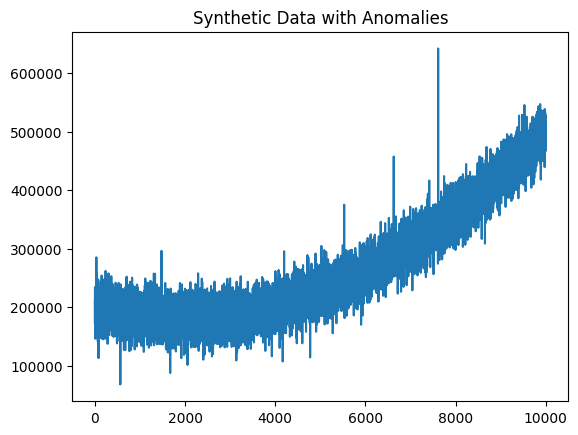

In [ ]:
# Параметри для генерації даних
length = 10000
noise_level = 24000
anomaly_chance = 0.004
poly_params = np.array([0.005, -20, 200000])
generated_data = create_synthetic_data(length, noise_level, anomaly_chance, poly_params)
# Візуалізація даних
plt.plot(generated_data)
plt.title('Synthetic Data with Anomalies')
plt.show()

In [ ]:
# Підготовка даних для подальшої обробки
generated_data = generated_data.reset_index(name='values')
generated_data = generated_data.rename(columns={'index': 'X'})
generated_data

,X,values
0,0,211314.443930
1,1,171396.588327
2,2,234344.987242
3,3,192436.399494
4,4,182625.950399
...,...,...
9995,9995,474445.740706
9996,9996,480989.253368
9997,9997,474500.988353
9998,9998,487895.385599


In [ ]:
# Функція для виявлення та корекції аномалій за допомогою ковзного вікна та IQR
def iqr_outlier_detection(data_sample, window, min_thresh=1, max_thresh=2):
    min_diff = np.inf
    thresh_range = np.round(np.arange(min_thresh, max_thresh + 0.1, 0.1), 2)

    for current_thresh in thresh_range:
        sample_copy = data_sample.copy()
        data_values = sample_copy['values'].values

        for j in range(len(sample_copy) - window + 1):
            window_data = data_values[j: j + window]
            q1 = np.percentile(window_data, 25)
            q3 = np.percentile(window_data, 75)
            iqr_value = q3 - q1

            if data_values[j] > (q3 + current_thresh * iqr_value) or data_values[j] < (q1 - current_thresh * iqr_value):
                data_values[j] = np.median(window_data)

        # Застосування поліноміальної регресії та визначення відстані між коефіцієнтами
        poly_model = Polynomial.fit(sample_copy.X, sample_copy['values'], 2)
        current_coefs = poly_model.convert().coef

        sc = StandardScaler()
        scaled_true_coefs = sc.fit_transform(np.array(poly_params).reshape(1, -1))
        scaled_calculated_coefs = sc.transform(np.array(current_coefs).reshape(1, -1))
        current_diff = np.linalg.norm(scaled_true_coefs - scaled_calculated_coefs)

        if current_diff < min_diff:
            min_diff = current_diff
            best_thresh = current_thresh
            best_sample = sample_copy.copy()

    return best_thresh, best_sample


In [ ]:
# Визначення найкращого порогу для видалення аномалій
optimal_thresh, processed_data = iqr_outlier_detection(generated_data, 8)
print(f'Best threshold: {optimal_thresh}')

Best threshold: 1.0


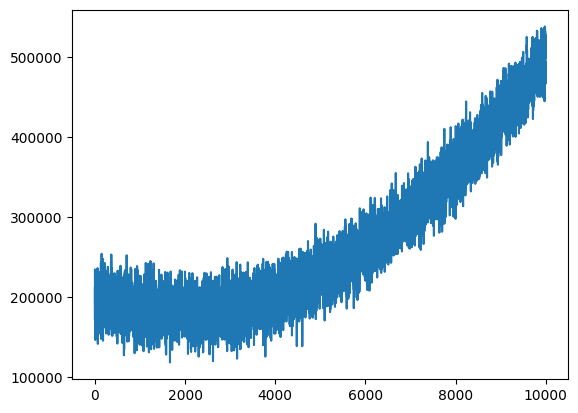

In [ ]:
# Візуалізація очищених даних
plt.plot(processed_data['values'])
plt.show()

In [ ]:
# Розбиття даних на навчальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(processed_data['X'].values.reshape(-1, 1), processed_data['values'], test_size=0.1, random_state=1234)
# Побудова поліноміальної регресії
poly_regression_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_regression_model.fit(X_train, y_train)
# Прогнозування та оцінка моделі
preds = poly_regression_model.predict(X_test)
print(f'R-squared value: {poly_regression_model.score(X_test, y_test)}')

R-squared value: 0.9560351380873512


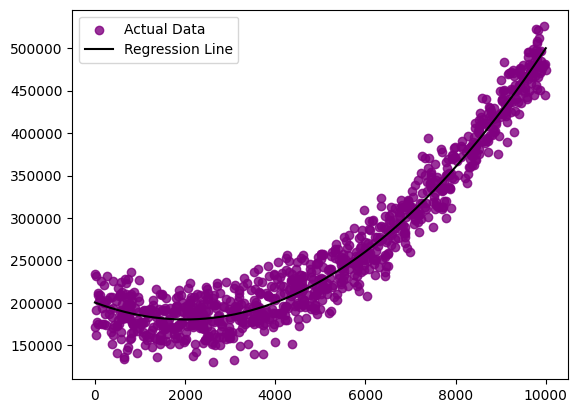

In [ ]:
# Візуалізація результатів регресії
plt.scatter(X_test, y_test, label='Actual Data', alpha=0.8, color='purple')
preds_all = poly_regression_model.predict(processed_data['X'].values.reshape(-1, 1))
plt.plot(processed_data['X'], preds_all, label='Regression Line', color='black')
plt.legend()
plt.show()

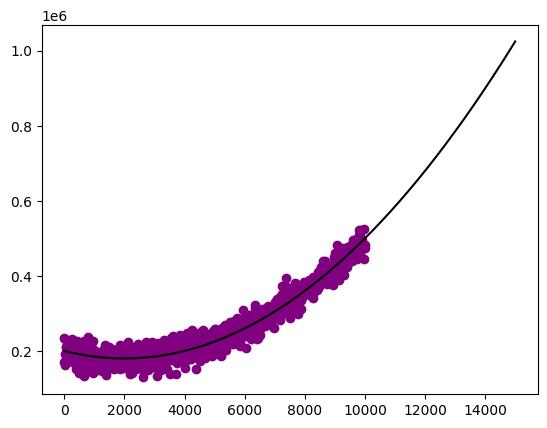

In [ ]:
# Прогнозування на більшій вибірці (розширені дані)
X_extended = np.arange(0, processed_data['X'].max() + 0.5 * length)
X_future = X_extended.reshape(-1, 1)
extended_predictions = poly_regression_model.predict(X_future)
# Візуалізація прогнозів на розширеній вибірці
plt.plot(X_future, extended_predictions, color='black')
plt.scatter(X_test, y_test, color='purple')
plt.show()

In [ ]:
# Статистичні характеристики прогнозованих даних
print(f'Mean: {extended_predictions.mean():.2f}')
print(f'Standard deviation: {extended_predictions.std():.2f}')

Mean: 425117.56
Standard deviation: 252049.89
